In [3]:
from load_data import read_data
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import os

In [4]:
# Create a map for timestamp correspondence
def create_timestamp_mapping(cam_ts, vicon_ts):
    cam_time_map = {}
    for ts in cam_ts[0]:  # Camera timestamps
        temp = np.abs(vicon_ts[0] - ts)
        index = np.argmin(temp)  # Find the closest Vicon timestamp for each camera timestamp
        cam_time_map[ts] = index
    return cam_time_map
    
def create_panorama(vicon_data, cam_data, cam_time_map):
    PIXEL_V, PIXEL_H = 230, 230  # Pixel grid size
    WIDTH,HEIGHT = 320, 240
    # Adjusted FOV for the camera
    FOV_V, FOV_H = 120, 240  # Vertical and Horizontal Field of View
    
    phi, theta = np.linspace(90 - (FOV_V / 2), 90 + (FOV_V / 2) - 1, PIXEL_V) * np.pi / 180, \
                 np.linspace(90 - (FOV_H / 2), 90 + (FOV_H / 2) - 1, PIXEL_H) * np.pi / 180

    cartesian = np.ones((PIXEL_V, PIXEL_H, 3))
    for i in range(phi.shape[0]):
        cartesian[i, :, 0] = np.cos(theta)
    for i in range(theta.shape[0]):
        cartesian[:, i, 1] = np.cos(phi)
    for i in range(phi.shape[0]):
        cartesian[i, :, 2] = np.sin(theta)
    print('Created cartesian coordinates map')

    world_frame_cartesian = np.zeros((PIXEL_V, PIXEL_H, 3, len(cam_time_map)), dtype=np.float32)

    # Transform the camera data into world coordinates
    for i in range(len(cam_time_map)):
        world_frame_cartesian[:, :, :, i] = np.dot(cartesian, vicon_data['rots'][:, :, cam_time_map[list(cam_time_map.keys())[i]]])
    print('Created world frame')

    spherical_from_cartesian = np.zeros((PIXEL_V, PIXEL_H, 3, len(cam_time_map)), dtype=np.float32)

    spherical_from_cartesian_r = np.linalg.norm(world_frame_cartesian, axis=2)
    spherical_from_cartesian[:, :, 0, :] = spherical_from_cartesian_r  # rho => z
    spherical_from_cartesian[:, :, 1, :] = np.arctan2(world_frame_cartesian[:, :, 1, :], world_frame_cartesian[:, :, 0, :])  # theta => x
    spherical_from_cartesian[:, :, 2, :] = np.arccos(world_frame_cartesian[:, :, 2, :] / spherical_from_cartesian_r)  # phi => y

    # Map spherical coordinates to pixel grid
    sx, sy = (2 * np.pi / WIDTH), (np.pi / HEIGHT)
    spherical_from_cartesian[:, :, 1, :] += np.pi
    spherical_from_cartesian[:, :, 1, :] /= sx
    spherical_from_cartesian[:, :, 2, :] /= sy
    spherical_from_cartesian[:, :, 2, :] -= np.min(spherical_from_cartesian[:, :, 2, :])
    spherical_from_cartesian[:, :, 1, :] -= np.min(spherical_from_cartesian[:, :, 1, :])
    spherical_from_cartesian = spherical_from_cartesian.astype(np.int32)
    print('Created spherical projection map\nCreating image:')

    # Generate the panorama image
    image = np.zeros((HEIGHT, WIDTH, 3)).astype(np.uint8)
    for r in tqdm(range(0, len(cam_time_map), 30)):  # Skip frames for testing
        for i in range(PIXEL_V):
            for j in range(PIXEL_H):
                _, x, y = spherical_from_cartesian[i, j, :, r]
                if 0 <= x < WIDTH and 0 <= y < HEIGHT:
                    image[y, x, :] = cam_data['cam'][i, j, :, r]


    print('Image created')
    return image


Created cartesian coordinates map
Created world frame
Created spherical projection map
Creating image:


100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


Image created


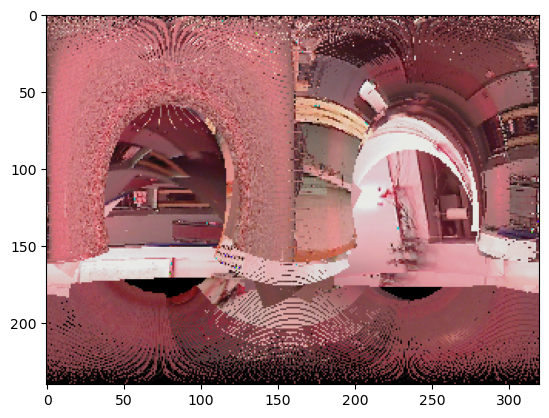

In [5]:
# Load VICON data
vfile = "data/vicon/viconRot2.p"
vicd = read_data(vfile)

# Extract rotation matrices
rotation_matrices = vicd['rots']# Shape: (3, 3, 5561)
vicon_timestamps = vicd['ts'][0]

# Load camera data
cfile = "data/cam/cam2.p"
camd = read_data(cfile)

# Extract camera images and timestamps
cam_images = camd['cam']  # List of camera images
#cam_timestamps = camd['ts'][0]  # Timestamps for camera images

cam_time_map = create_timestamp_mapping(camd['ts'], vicd['ts'])
#if len(cam_images[0].shape) == 2:  # Check if the image is grayscale
    #cam_images = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in cam_images]# Extract VICON timestamps (assuming they are stored in vicd['ts'])
#panorama_images = []
panorama_image = create_panorama(vicd, camd, cam_time_map)
#panorama_images.append(panorama_image)


# Save or display the panorama

plt.imshow(panorama_image)
plt.show()

Created cartesian coordinates map
Created world frame
Created spherical projection map
Creating image:


100%|██████████| 57/57 [00:24<00:00,  2.28it/s]


Image created


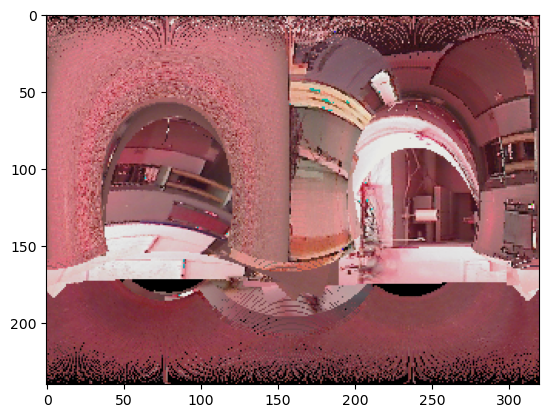

In [6]:
# Load VICON data
vfile = "data/vicon/viconRot1.p"
vicd = read_data(vfile)

# Extract rotation matrices
rotation_matrices = vicd['rots']# Shape: (3, 3, 5561)
vicon_timestamps = vicd['ts'][0]

# Load camera data
cfile = "data/cam/cam1.p"
camd = read_data(cfile)

# Extract camera images and timestamps
cam_images = camd['cam']  # List of camera images
#cam_timestamps = camd['ts'][0]  # Timestamps for camera images

cam_time_map = create_timestamp_mapping(camd['ts'], vicd['ts'])
#if len(cam_images[0].shape) == 2:  # Check if the image is grayscale
    #cam_images = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in cam_images]# Extract VICON timestamps (assuming they are stored in vicd['ts'])
#panorama_images = []
panorama_image = create_panorama(vicd, camd, cam_time_map)
#panorama_images.append(panorama_image)


# Save or display the panorama

plt.imshow(panorama_image)
plt.show()